In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

from datetime import datetime, timedelta

In [2]:
pd.set_option('display.max_rows', 500)

In [3]:
file_path = 'C:/Users/Jacob/Documents/datasets/mimic-iv-0.4/'
save_path = 'C:/Users/Jacob/Documents/datasets/mimic-iv-0.4-processed/'
if not os.path.exists(save_path):
    os.mkdir(save_path)

In [4]:
adm = pd.read_csv(os.path.join(file_path, 'core', 'admissions.csv'))
adm.head()

subject_id   hadm_id            admittime            dischtime deathtime  \
0    12427812  21593330  2184-01-06 11:51:00  2184-01-10 11:45:00       NaN   
1    14029832  22059088  2120-01-18 01:28:00  2120-01-20 16:13:00       NaN   
2    14495017  22484010  2175-01-28 15:41:00  2175-01-29 16:00:00       NaN   
3    13676048  23865469  2193-01-19 05:27:00  2193-01-24 18:59:00       NaN   
4    13831972  27763544  2131-01-27 04:03:00  2131-01-27 05:39:00       NaN   

   admission_type      admission_location discharge_location insurance  \
0          URGENT      PHYSICIAN REFERRAL               HOME     Other   
1          URGENT  TRANSFER FROM HOSPITAL               HOME     Other   
2    DIRECT EMER.      PHYSICIAN REFERRAL               HOME     Other   
3          URGENT      PHYSICIAN REFERRAL               HOME     Other   
4  EU OBSERVATION          EMERGENCY ROOM                NaN  Medicaid   

  language marital_status ethnicity            edregtime            edouttime  \
0  ENGLISH            NaN   UNKNOWN                  NaN                  NaN   
1  ENGLISH            NaN     OTHER                  NaN                  NaN   
2        ?            NaN     WHITE                  NaN                  NaN   
3        ?        MARRIED     WHITE                  NaN                  NaN   
4  ENGLISH         SINGLE     WHITE  2131-01-26 22:19:00  2131-01-27 05:39:00   

   hospital_expire_flag  
0                     0  
1                     0  
2                     0  
3                     0  
4                     0

In [5]:
icu = pd.read_csv(os.path.join(file_path, 'icu', 'icustays.csv'))
icu.head()

subject_id   hadm_id   stay_id            first_careunit  \
0    17823467  27561644  35964304  Coronary Care Unit (CCU)   
1    15772648  26147926  39637383       Trauma SICU (TSICU)   
2    13713711  25848902  36363748       Trauma SICU (TSICU)   
3    13173210  22338446  38210858  Coronary Care Unit (CCU)   
4    10213765  28522861  39765853       Trauma SICU (TSICU)   

              last_careunit               intime              outtime  \
0  Coronary Care Unit (CCU)  2138-05-09 05:08:00  2138-05-11 16:55:34   
1       Trauma SICU (TSICU)  2146-06-18 18:35:00  2146-06-21 17:41:00   
2       Trauma SICU (TSICU)  2157-09-15 15:30:00  2157-09-17 18:18:49   
3  Coronary Care Unit (CCU)  2178-02-12 17:13:50  2178-02-15 14:55:14   
4       Trauma SICU (TSICU)  2113-04-10 14:11:00  2113-04-11 10:55:19   

        los  
0  2.491366  
1  2.962500  
2  2.117234  
3  2.903750  
4  0.864109

In [6]:
pat = pd.read_csv(os.path.join(file_path, 'core', 'patients.csv'))
pat.tail()

subject_id gender  anchor_age  anchor_year anchor_year_group  dod
383215    19998203      M          29         2132       2011 - 2013  NaN
383216    19998350      M          52         2127       2011 - 2013  NaN
383217    19999068      M          63         2161       2011 - 2013  NaN
383218    19999270      M          33         2184       2014 - 2016  NaN
383219    19999298      M          20         2177       2011 - 2013  NaN

In [7]:
print(len(adm))
adm = adm[adm["subject_id"].isin(list(icu["subject_id"]))]
print(len(adm))

524520
176287


In [8]:
adm = pd.merge(adm, pat, on="subject_id")

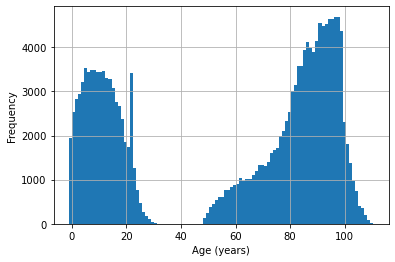

In [9]:
# Calculate the age of a patient on admission to the hospital.
adm['anchor_year'] = pd.to_datetime(adm['anchor_year'], format='%Y')
adm['anchor_age'] = pd.to_datetime(adm['anchor_age'], format='%y')
adm['admittime'] = pd.to_datetime(adm['admittime'], format='%Y-%m-%d %H:%M:%S')
adm['age'] = (adm['admittime'] - adm['anchor_year'] + adm['anchor_age'] - pd.Timestamp("1970-01-01")) / pd.Timedelta('1s') / (365 * 24 * 3600)
adm['age'].hist(bins=100)
_ = plt.xlabel('Age (years)'), plt.ylabel('Frequency')

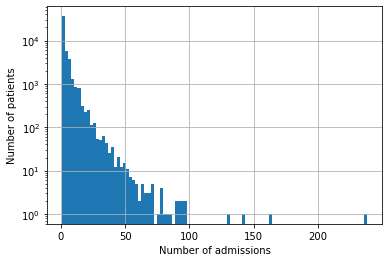

(None,
 Text(0.5, 17.200000000000003, 'Number of admissions'),
 Text(17.200000000000006, 0.5, 'Number of patients'),
 None)

In [10]:
# Number of admissions by patient
df = adm.groupby('subject_id')['hadm_id'].nunique()
fig, ax = plt.subplots()
df.hist(ax=ax, bins=100)
ax.set_yscale('log'), plt.xlabel('Number of admissions'), plt.ylabel('Number of patients'), plt.show()

In [11]:
# Filter patients with more than 1 admission
adm = adm.loc[adm['subject_id'].isin(list(df[df==1].index))]
print("Number of patients remaining in the dataframe: ")
print(len(adm.index))

Number of patients remaining in the dataframe: 
21725


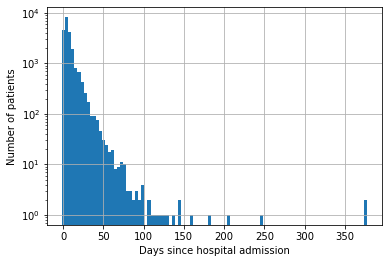

(None,
 Text(0.5, 17.200000000000003, 'Days since hospital admission'),
 Text(17.200000000000006, 0.5, 'Number of patients'),
 None)

In [12]:
# Add a new column with the duration of each stay.
adm['dischtime'] = pd.to_datetime(adm["dischtime"], format='%Y-%m-%d %H:%M:%S')
adm['elapsed_time'] = adm['dischtime'] - adm['admittime']
adm['elapsed_days'] = adm['elapsed_time'].dt.days  # Elapsed time in days in ICU
fig, ax = plt.subplots()
adm["elapsed_days"].hist(ax=ax, bins=100)
_ = ax.set_yscale('log'), plt.xlabel('Days since hospital admission'), plt.ylabel('Number of patients'), plt.show()

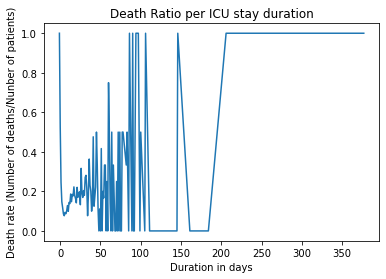

In [13]:
# The death rate in function of the duration stay in ICU.
df_deaths_per_duration = adm.groupby('elapsed_days')['hospital_expire_flag'].sum()
df_patients_per_duration = adm.groupby('elapsed_days')['subject_id'].nunique()
df_death_ratio_per_duration = df_deaths_per_duration / df_patients_per_duration
plt.plot(df_death_ratio_per_duration)
plt.title("Death Ratio per ICU stay duration")
plt.xlabel("Duration in days")
plt.ylabel("Death rate (Number of deaths/Nunber of patients)")
plt.show()

In [14]:
adm = adm.loc[(adm["elapsed_days"] < 30) & (adm["elapsed_days"] > 2)]
print("Number of patients with more than 2 and less than 30 days: ")
print(adm['subject_id'].nunique(), len(adm))

Number of patients with more than 2 and less than 30 days: 
16572 16572


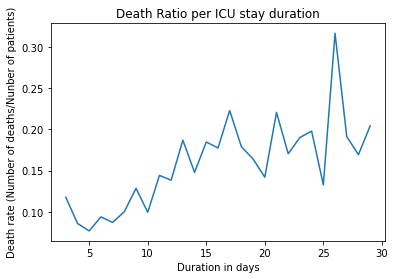

In [15]:
# The death rate in function of the duration stay in ICU.
df_deaths_per_duration = adm.groupby('elapsed_days')['hospital_expire_flag'].sum()
df_patients_per_duration = adm.groupby('elapsed_days')['subject_id'].nunique()
df_death_ratio_per_duration = df_deaths_per_duration / df_patients_per_duration
plt.plot(df_death_ratio_per_duration)
plt.title("Death Ratio per ICU stay duration")
plt.xlabel("Duration in days")
plt.ylabel("Death rate (Number of deaths/Nunber of patients)")
plt.show()

In [16]:
# Remove the patients younger than 16
adm = adm.loc[adm["age"] >= 16]
print("Number of patients 16 or older:")
print(len(adm))

Number of patients 16 or older:
10820


In [17]:
df_type = adm.groupby("admission_type")["subject_id"].count()
df_type

admission_type
AMBULATORY OBSERVATION            1
DIRECT EMER.                    232
DIRECT OBSERVATION                3
ELECTIVE                        358
EU OBSERVATION                    5
EW EMER.                       5297
OBSERVATION ADMIT              1153
SURGICAL SAME DAY ADMISSION    1256
URGENT                         2515
Name: subject_id, dtype: int64

In [18]:
adm.to_csv(os.path.join(save_path, "icu", 'admissions.csv'))

## INPUT EVENTS DATA (ICU)

In [19]:
inp = pd.read_csv(os.path.join(file_path, "icu", "inputevents.csv"))
print(inp.shape)
inp = inp.loc[inp['subject_id'].isin(adm['subject_id'])]
print(inp.shape)
inp.head()

(8869715, 26)
(1577636, 26)


subject_id   hadm_id   stay_id            starttime              endtime  \
616    12422371  22216078  33954680  2137-08-19 08:00:00  2137-08-19 08:01:00   
617    12422371  22216078  33954680  2137-08-20 07:59:00  2137-08-20 08:00:00   
618    12422371  22216078  33954680  2137-08-19 08:00:00  2137-08-19 08:01:00   
619    12422371  22216078  33954680  2137-08-19 18:00:00  2137-08-19 18:01:00   
620    12422371  22216078  33954680  2137-08-19 08:00:00  2137-08-19 08:01:00   

               storetime  itemid  amount amountuom  rate  ...  \
616  2137-08-19 08:11:00  226452   240.0        ml   NaN  ...   
617  2137-08-20 07:59:00  226452   100.0        ml   NaN  ...   
618  2137-08-19 08:11:00  225975     1.0      dose   NaN  ...   
619  2137-08-19 18:57:00  226452   480.0        ml   NaN  ...   
620  2137-08-19 08:11:00  225910     1.0      dose   NaN  ...   

    ordercategorydescription  patientweight  totalamount totalamountuom  \
616                    Bolus          175.0        240.0             ml   
617                    Bolus          175.0        100.0             ml   
618                Drug Push          175.0          NaN            NaN   
619                    Bolus          175.0        480.0             ml   
620                Drug Push          175.0          NaN            NaN   

    isopenbag continueinnextdept cancelreason  statusdescription  \
616         0                  0            0    FinishedRunning   
617         0                  0            0    FinishedRunning   
618         0                  0            0    FinishedRunning   
619         0                  0            0    FinishedRunning   
620         0                  0            0    FinishedRunning   

     originalamount originalrate  
616           240.0        240.0  
617           100.0        100.0  
618             1.0          1.0  
619           480.0        480.0  
620             1.0          0.0  

[5 rows x 26 columns]

In [20]:
inp['subject_id'].nunique()

10809

In [21]:
# Item ID table
item_id = pd.read_csv(os.path.join(file_path, "icu", "d_items.csv"))
item_id = item_id[["itemid", "label"]]
item_id.head()

itemid                    label
0  220003       ICU Admission date
1  220045               Heart Rate
2  220046  Heart rate Alarm - High
3  220047   Heart Rate Alarm - Low
4  220048             Heart Rhythm

In [22]:
# Merge the name of the item administrated.
inp = pd.merge(inp, item_id, on="itemid")
inp.head()

subject_id   hadm_id   stay_id            starttime              endtime  \
0    12422371  22216078  33954680  2137-08-19 08:00:00  2137-08-19 08:01:00   
1    12422371  22216078  33954680  2137-08-20 07:59:00  2137-08-20 08:00:00   
2    12422371  22216078  33954680  2137-08-19 18:00:00  2137-08-19 18:01:00   
3    12422371  22216078  33954680  2137-08-20 12:17:00  2137-08-20 12:18:00   
4    12422371  22216078  33954680  2137-08-20 09:00:00  2137-08-20 09:01:00   

             storetime  itemid  amount amountuom  rate  ... patientweight  \
0  2137-08-19 08:11:00  226452   240.0        ml   NaN  ...         175.0   
1  2137-08-20 07:59:00  226452   100.0        ml   NaN  ...         175.0   
2  2137-08-19 18:57:00  226452   480.0        ml   NaN  ...         175.0   
3  2137-08-20 12:18:00  226452   300.0        ml   NaN  ...         175.0   
4  2137-08-20 10:08:00  226452   350.0        ml   NaN  ...         175.0   

   totalamount  totalamountuom isopenbag continueinnextdept cancelreason  \
0        240.0              ml         0                  0            0   
1        100.0              ml         0                  0            0   
2        480.0              ml         0                  0            0   
3        300.0              ml         0                  0            0   
4        350.0              ml         0                  0            0   

  statusdescription  originalamount  originalrate      label  
0   FinishedRunning           240.0         240.0  PO Intake  
1   FinishedRunning           100.0         100.0  PO Intake  
2   FinishedRunning           480.0         480.0  PO Intake  
3   FinishedRunning           300.0         300.0  PO Intake  
4   FinishedRunning           350.0         350.0  PO Intake  

[5 rows x 27 columns]

In [23]:
# Keep 50 most frequent input events
inp = inp.loc[inp["label"].isin(inp["label"].value_counts().index.to_list()[:50])]
print(inp.shape)

(1419596, 27)


In [24]:
# Verification that all input labels have the same amounts units.
inp.groupby("label")["amountuom"].value_counts(dropna=False)

label                            amountuom
Acetaminophen-IV                 mg            13231
                                 grams            15
Albumin 5%                       ml             4434
Calcium Gluconate                grams         12175
Calcium Gluconate (CRRT)         grams          4606
Cefazolin                        dose           9133
                                 grams           241
                                 mg                9
Cefepime                         dose           8799
                                 grams           330
                                 mg                3
D5 1/2NS                         ml             4878
                                 L                 3
Dexmedetomidine (Precedex)       mcg           21582
                                 mg              971
Dextrose 5%                      ml           174874
Famotidine (Pepcid)              dose          12732
                                 mg               97
   

### Cleaning

In [25]:
# Acetaminophen-IV - convert grams to mg
cond = (inp["label"] == "Acetaminophen-IV") & (inp["amountuom"] == "grams")
inp["amount"] += 999 * cond * inp["amount"]
inp["amountuom"].loc[cond] = "mg"

# Cefazolin - remove non-dose unit
inp = inp.drop(inp.loc[(inp["label"] == "Cefazolin") & (inp["amountuom"] != "dose")].index)

# Cefepime - remove non-dose unit
inp = inp.drop(inp.loc[(inp["label"] == "Cefepime") & (inp["amountuom"] != "dose")].index)

# D5 1/2NS - convert L to ml
cond = (inp["label"] == "D5 1/2NS") & (inp["amountuom"] == "L")
inp["amount"] += 999 * cond * inp["amount"]
inp["amountuom"].loc[cond] = "ml"

# Dexmedetomidine (Precedex) - convert mg to mcg
cond = (inp["label"] == "Dexmedetomidine (Precedex)") & (inp["amountuom"] == "mg")
inp["amount"] += 999 * cond * inp["amount"]
inp["amountuom"].loc[cond] = "mcg"

# Famotidine (Pepcid) - remove non-dose unit
inp = inp.drop(inp.loc[(inp["label"] == "Famotidine (Pepcid)") & (inp["amountuom"] != "dose")].index)

# Fentanyl - convert mg to mcg
inp["label"].loc[inp["label"] == "Fentanyl (Concentrate)"] = "Fentanyl"
cond = (inp["label"] == "Fentanyl") & (inp["amountuom"] == "mg")
inp["amount"] += 999 * cond * inp["amount"]
inp["amountuom"].loc[cond] = "mcg"

# Heparin Sodium (Prophylaxis)
inp = inp.drop(inp.loc[(inp["label"] == "Heparin Sodium (Prophylaxis)") & (inp["amountuom"] != "dose")].index)

# Hydromorphone (Dilaudid) - remove non-mg unit
inp = inp.drop(inp.loc[(inp["label"] == "Hydromorphone (Dilaudid)") & (inp["amountuom"] != "mg")].index)

# Labetalol - remove non-mg unit
inp = inp.drop(inp.loc[(inp["label"] == "Labetalol") & (inp["amountuom"] != "mg")].index)

# LR - remove non-ml unit
inp = inp.drop(inp.loc[(inp["label"] == "LR") & (inp["amountuom"] != "ml")].index)

# Magnesium Sulfate - convert mg to grams
cond = (inp["label"] == "Magnesium Sulfate") & (inp["amountuom"] == "mg")
inp["amount"] -= 0.999 * cond * inp["amount"]
inp["amountuom"].loc[cond] = "grams"

# Metronidazole - remove non-dose unit
inp = inp.drop(inp.loc[(inp["label"] == "Metronidazole") & (inp["amountuom"] != "dose")].index)

# NaCl 0.9% - convert L to ml
cond = (inp["label"] == "NaCl 0.9%") & (inp["amountuom"] == "L")
inp["amount"] += 999 * cond * inp["amount"]
inp["amountuom"].loc[cond] = "ml"

# OR Crystalloid Intake - convert L to ml
cond = (inp["label"] == "OR Crystalloid Intake") & (inp["amountuom"] == "L")
inp["amount"] += 999 * cond * inp["amount"]
inp["amountuom"].loc[cond] = "ml"

# Pantoprazole (Protonix) - remove non-dose unit
inp = inp.drop(inp.loc[(inp["label"] == "Pantoprazole (Protonix)") & (inp["amountuom"] != "dose")].index)

# Piperacillin/Tazobactam (Zosyn) - remove non-dose unit
inp = inp.drop(inp.loc[(inp["label"] == "Piperacillin/Tazobactam (Zosyn)") & (inp["amountuom"] != "dose")].index)

# PO Intake - remove non-ml (pico-litres seems like a mistake)
inp = inp.drop(inp.loc[(inp["label"] == "PO Intake") & (inp["amountuom"] != "ml")].index)

# Propofol - convert mcg to mg
cond = (inp["label"] == "Propofol") & (inp["amountuom"] == "mcg")
inp["amount"] -= 0.999 * cond * inp["amount"]
inp["amountuom"].loc[cond] = "mg"

# Vancomycin - remove non-dose unit
inp = inp.drop(inp.loc[(inp["label"] == "Vancomycin") & (inp["amountuom"] != "dose")].index)

inp.groupby("label")["amountuom"].value_counts(dropna=False)

label                            amountuom
Acetaminophen-IV                 mg            13246
Albumin 5%                       ml             4434
Calcium Gluconate                grams         12175
Calcium Gluconate (CRRT)         grams          4606
Cefazolin                        dose           9133
Cefepime                         dose           8799
D5 1/2NS                         ml             4881
Dexmedetomidine (Precedex)       mcg           22553
Dextrose 5%                      ml           174874
Famotidine (Pepcid)              dose          12732
Fentanyl                         mcg           65866
Free Water                       ml             9298
Furosemide (Lasix)               mg            14849
GT Flush                         ml            32495
Gastric Meds                     ml            43099
Heparin Sodium                   units         11142
Heparin Sodium (Prophylaxis)     dose          26664
Hydralazine                      mg             6242
Hyd

In [26]:
inp.groupby("label")["rateuom"].value_counts(dropna=False)

label                            rateuom    
Acetaminophen-IV                 NaN              8482
                                 mg/min           4763
                                 mg/hour             1
Albumin 5%                       mL/hour          4434
Calcium Gluconate                NaN             12175
Calcium Gluconate (CRRT)         grams/hour       4606
Cefazolin                        NaN              9133
Cefepime                         NaN              8799
D5 1/2NS                         mL/hour          4852
                                 NaN                29
Dexmedetomidine (Precedex)       mcg/kg/hour     22553
Dextrose 5%                      mL/hour        105570
                                 NaN             69304
Famotidine (Pepcid)              NaN             12732
Fentanyl                         NaN             39951
                                 mcg/hour        25914
                                 mcg/kg/hour         1
Free Water          

### Cleaning

In [27]:
# Acetaminophen-IV - convert mg/hour to mg/min
cond = (inp["label"] == "Acetaminophen-IV") & (inp["rateuom"] == "mg/hour")
inp["rate"] -= (59 / 60) * cond * inp["rate"]
inp["rateuom"].loc[cond] = "mg/min"

# Fentanyl - remove non-mcg/hour unit
inp = inp.drop(inp.loc[(inp["label"] == "Fentanyl") & (inp["amountuom"] != "mcg/hour")].index)

# NaCl 0.9% - convert mL/min to mL/hour
cond = (inp["label"] == "NaCl 0.9%") & (inp["rateuom"] == "mL/min")
inp["rate"] += 59 * cond * inp["rate"]
inp["rateuom"].loc[cond] = "mL/hour"

# Packed Red Blood Cells - convert mL/min to mL/hour
cond = (inp["label"] == "Packed Red Blood Cells") & (inp["rateuom"] == "mL/min")
inp["rate"] += 59 * cond * inp["rate"]
inp["rateuom"].loc[cond] = "mL/hour"

# Phenylephrine - remove non-mcg/kg/min unit
inp = inp.drop(inp.loc[(inp["label"] == "Phenylephrine") & (inp["amountuom"] != "mcg/kg/min")].index)

# Piggyback - convert mL/min to mL/hour
cond = (inp["label"] == "Piggyback") & (inp["rateuom"] == "mL/min")
inp["rate"] += 59 * cond * inp["rate"]
inp["rateuom"].loc[cond] = "mL/hour"

# Sterile Water
cond = (inp["label"] == "Sterile Water") & (inp["rateuom"] == "mL/min")
inp["rate"] += 59 * cond * inp["rate"]
inp["rateuom"].loc[cond] = "mL/hour"

inp.groupby("label")["rateuom"].value_counts(dropna=False)

label                            rateuom    
Acetaminophen-IV                 NaN              8482
                                 mg/min           4764
Albumin 5%                       mL/hour          4434
Calcium Gluconate                NaN             12175
Calcium Gluconate (CRRT)         grams/hour       4606
Cefazolin                        NaN              9133
Cefepime                         NaN              8799
D5 1/2NS                         mL/hour          4852
                                 NaN                29
Dexmedetomidine (Precedex)       mcg/kg/hour     22553
Dextrose 5%                      mL/hour        105570
                                 NaN             69304
Famotidine (Pepcid)              NaN             12732
Free Water                       NaN              9298
Furosemide (Lasix)               NaN             12473
                                 mg/hour          2376
GT Flush                         NaN             32495
Gastric Meds        

In [28]:
inp.groupby("label")["amount"].describe()

count         mean          std  \
label                                                                 
Acetaminophen-IV                  13246.0   988.270527    92.604117   
Albumin 5%                         4434.0   365.546418   130.138186   
Calcium Gluconate                 12175.0     2.198874     2.567602   
Calcium Gluconate (CRRT)           4606.0    10.751342    17.982831   
Cefazolin                          9133.0     1.002737     0.052251   
Cefepime                           8799.0     1.005569     0.074421   
D5 1/2NS                           4881.0   601.544141   399.480797   
Dexmedetomidine (Precedex)        22553.0   152.966414   168.325342   
Dextrose 5%                      174874.0   112.359845   147.638960   
Famotidine (Pepcid)               12732.0     1.000157     0.012533   
Free Water                         9298.0   164.949451   112.834507   
Furosemide (Lasix)                14849.0    37.215209    37.851513   
GT Flush                          32495.0    46.462871    51.387719   
Gastric Meds                      43099.0    58.248124    70.865750   
Heparin Sodium                    11142.0  9907.092612  8152.376515   
Heparin Sodium (Prophylaxis)      26664.0     1.618662    58.806721   
Hydralazine                        6242.0    12.069690     4.581757   
Hydromorphone (Dilaudid)          19942.0     1.835921     6.088389   
Insulin - Humalog                  9863.0     5.026594     4.324170   
Insulin - Regular                 51211.0     6.869633    10.427459   
KCL (Bolus)                       19125.0    57.505875    35.809223   
KCl (CRRT)                         6979.0     8.944199    10.999871   
LR                                22533.0   649.252719   351.922141   
Labetalol                          4779.0    51.730699   120.338352   
Lorazepam (Ativan)                 7839.0     1.278172     1.664306   
Magnesium Sulfate                 12832.0     2.126337     2.657942   
Magnesium Sulfate (Bolus)          9278.0    51.090340     8.344673   
Metoprolol                         8969.0     5.601372     3.070675   
Metronidazole                      7189.0     1.000000     0.000000   
Midazolam (Versed)                22540.0    13.735271    28.949116   
Morphine Sulfate                  15100.0     4.469641    10.741664   
NaCl 0.9%                        216891.0   143.568571   264.732011   
Nicardipine                        9677.0    13.299938    19.734861   
Nitroglycerin                     14788.0     8.089326    15.364076   
Norepinephrine                    48211.0     1.391767     2.446236   
OR Crystalloid Intake              4255.0  2339.795065  1494.524456   
PO Intake                         73356.0   190.439732   135.628188   
Packed Red Blood Cells             7188.0   331.112725   193.485503   
Pantoprazole (Protonix)            7200.0     1.008056     0.462443   
Piggyback                         18686.0   109.509172    99.729752   
Piperacillin/Tazobactam (Zosyn)    9580.0     1.166806    16.336756   
Potassium Chloride                33517.0    18.718578    19.763292   
Propofol                          89851.0   329.135361   357.890114   
Replete with Fiber (Full)          4422.0   368.863934   374.636562   
Solution                         118713.0    37.924552    38.299708   
Sterile Water                     10248.0    74.080590    57.724550   
Vancomycin                        20724.0     2.530810    44.385309   

                                        min          25%          50%  \
label                                                                   
Acetaminophen-IV                   0.000000  1000.000000  1000.000000   
Albumin 5%                         2.083333   249.999990   249.999999   
Calcium Gluconate                  0.048400     2.000000     2.000000   
Calcium Gluconate (CRRT)           0.013329     4.273034     8.532252   
Cefazolin                          1.000000     1.000000     1.000000   
Cefepime                           1.000000  

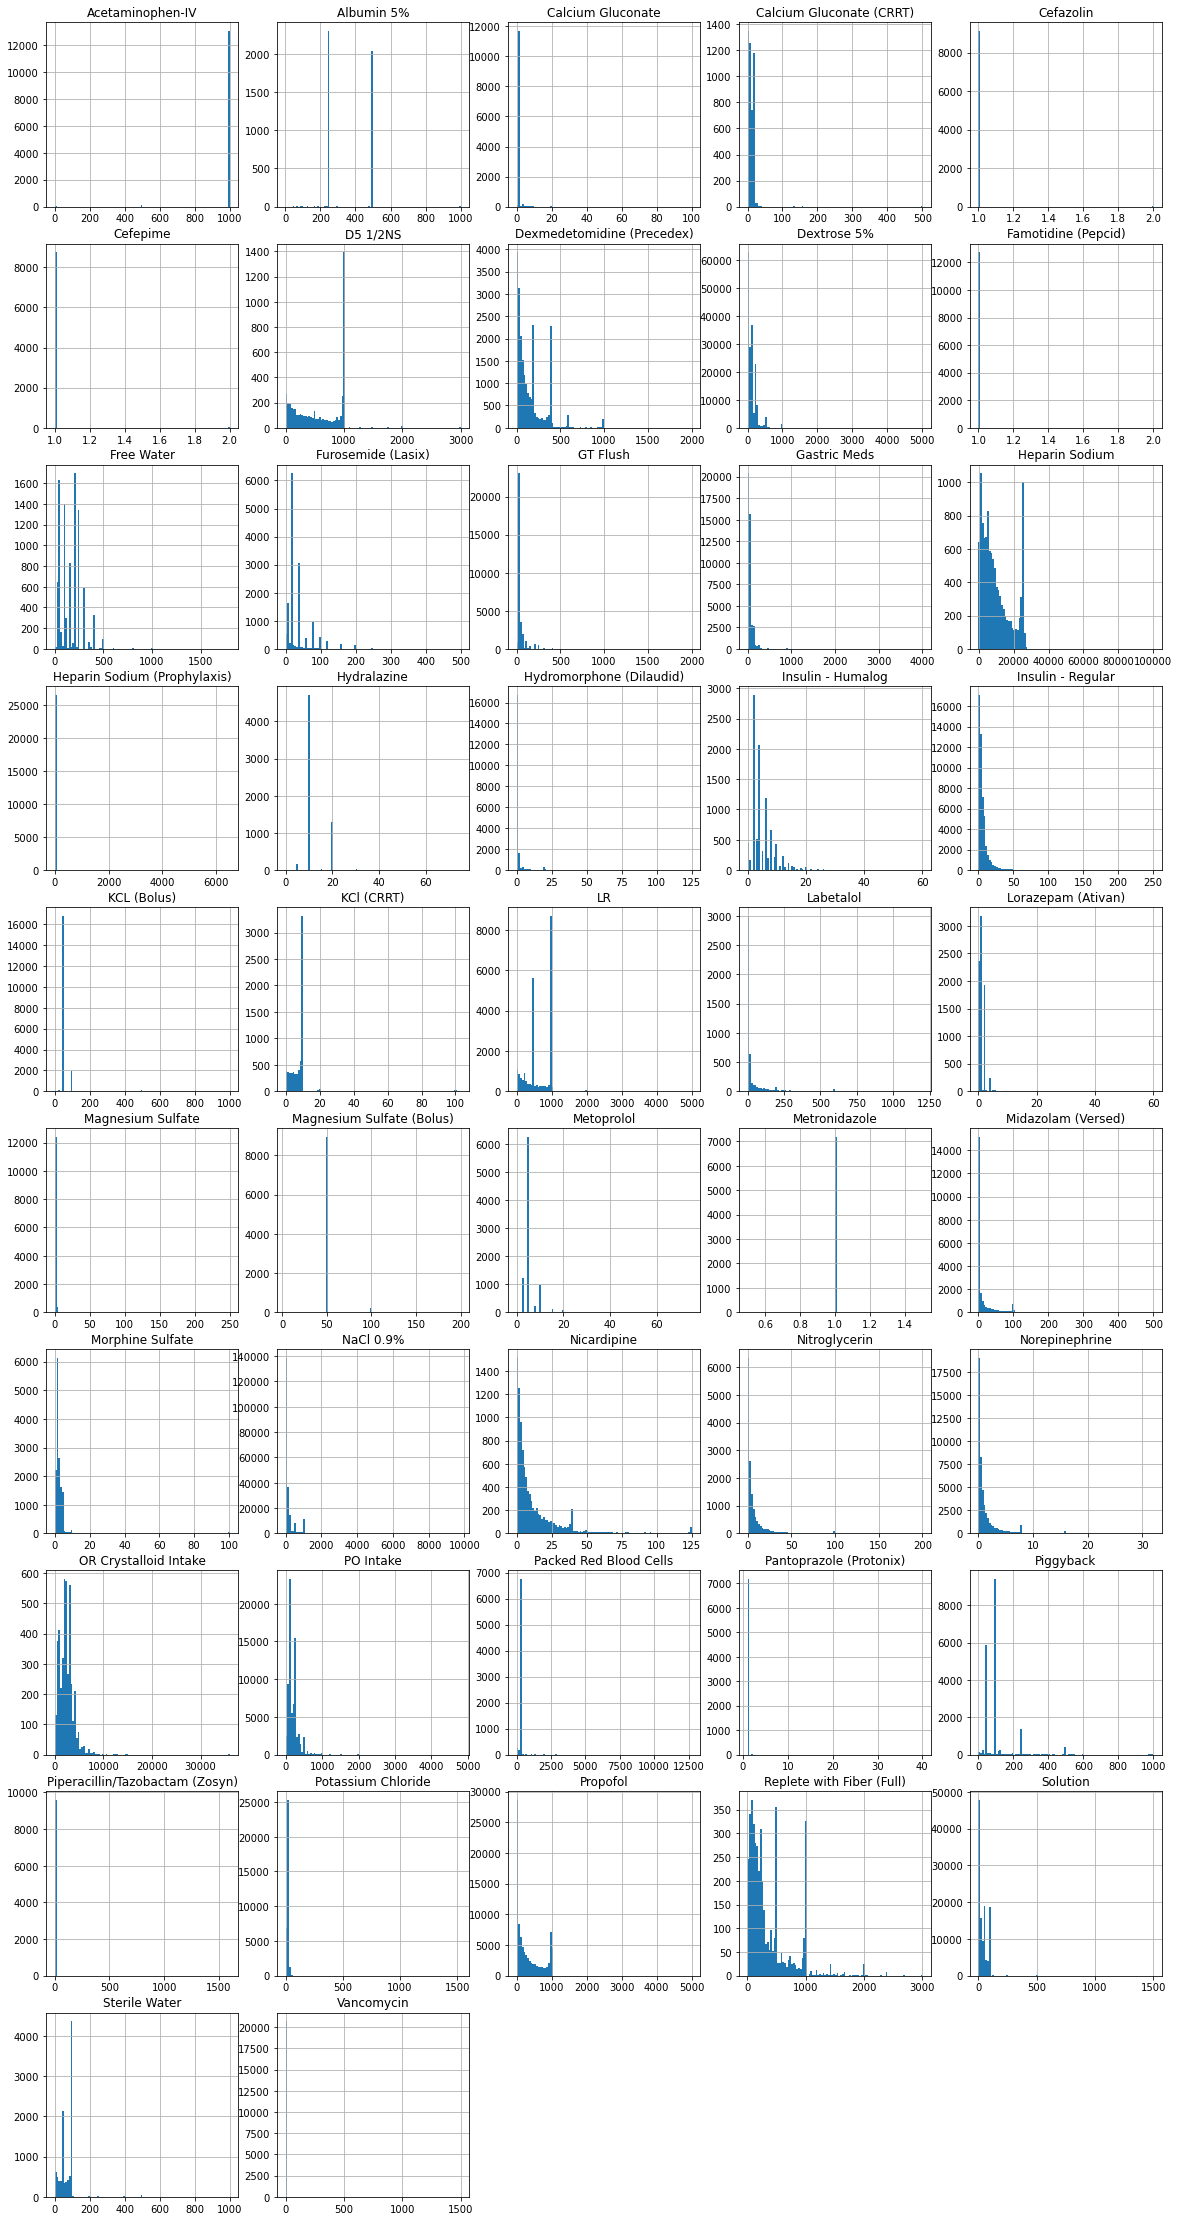

In [29]:
plt.figure(figsize=(20, 40))
for i, label in enumerate(sorted(inp["label"].unique())):
    plt.subplot(10, 5, 1+i)
    inp["amount"][inp["label"] == label].hist(bins=100)
    plt.title(label)

In [30]:
# Acetaminophen-IV - remove values under and floating point errors
inp = inp.drop(inp.loc[(inp["label"] == "Acetaminophen-IV") & (inp["amount"] < 1000)].index)
inp["amount"].loc[inp["label"] == "Acetaminophen-IV"] = 1000

# Albumin 5% - remove values over 500
inp = inp.drop(inp.loc[(inp["label"] == "Albumin 5%") & (inp["amount"] > 500)].index)

# Calcium Gluconate - remove values over 10
inp = inp.drop(inp.loc[(inp["label"] == "Calcium Gluconate") & (inp["amount"] > 10)].index)

# Calcium Gluconate (CRRT) - remove values over 20
inp = inp.drop(inp.loc[(inp["label"] == "Calcium Gluconate (CRRT)") & (inp["amount"] > 20)].index)

# Cefazolin - remove values over 1.0
inp = inp.drop(inp.loc[(inp["label"] == "Cefazolin") & (inp["amount"] > 1)].index)

# Cefepime - remove values over 1.0
inp = inp.drop(inp.loc[(inp["label"] == "Cefepime") & (inp["amount"] > 1)].index)

# Dexmedetomidine (Precedex) - remove values over 1000
inp = inp.drop(inp.loc[(inp["label"] == "Dexmedetomidine (Precedex)") & (inp["amount"] > 1000)].index)

# Dextrose 5% - remove values over 1000
inp = inp.drop(inp.loc[(inp["label"] == "Dextrose 5%") & (inp["amount"] > 1000)].index)

# Epinephrine - ???

# Famotidine (Pepcid)

# Fentanyl - ???

# Free Water - remove values over 500
inp = inp.drop(inp.loc[(inp["label"] == "Free Water") & (inp["amount"] > 500)].index)

# Furosemide (Lasix) - ???
# Furosemide (Lasix) - remove values over 300
inp = inp.drop(inp.loc[(inp["label"] == "Furosemide (Lasix)") & (inp["amount"] > 300)].index)

# GT Flush - remove values over 500
inp = inp.drop(inp.loc[(inp["label"] == "GT Flush") & (inp["amount"] > 500)].index)

# Gastric Meds - ???

# Heparin Sodium

# Heparin Sodium (Prophylaxis)

# Hydralazine

# Hydromorphone (Dilaudid) - ???
# Hydromorphone (Dilaudid) - remove values over 20
inp = inp.drop(inp.loc[(inp["label"] == "Hydromorphone (Dilaudid)") & (inp["amount"] > 20)].index)

# Insulin - Glargine - ???

# Insulin - Humalog

# Insulin - Regular

# KCL (Bolus) - ???
# KCL (Bolus) - remove values over 100
inp = inp.drop(inp.loc[(inp["label"] == "KCL (Bolus)") & (inp["amount"] > 100)].index)

# KCl (CRRT) - remove values over 10
inp = inp.drop(inp.loc[(inp["label"] == "KCl (CRRT)") & (inp["amount"] > 10)].index)

# LR - remove values over 1000
inp = inp.drop(inp.loc[(inp["label"] == "LR") & (inp["amount"] > 1000)].index)

# Labetalol

# Lorazepam (Ativan) - remove values over 10
inp = inp.drop(inp.loc[(inp["label"] == "Lorazepam (Ativan)") & (inp["amount"] > 10)].index)

# Magnesium Sulfate	- remove values over 2
inp = inp.drop(inp.loc[(inp["label"] == "Magnesium Sulfate") & (inp["amount"] > 2)].index)

# Magnesium Sulfate (Bolus) - remove values over 100
inp = inp.drop(inp.loc[(inp["label"] == "Magnesium Sulfate (Bolus)") & (inp["amount"] > 100)].index)

# Metoprolol - remove values over 20
inp = inp.drop(inp.loc[(inp["label"] == "Metoprolol") & (inp["amount"] > 20)].index)

# Metronidazole

# Midazolam (Versed) - remove values over 100
inp = inp.drop(inp.loc[(inp["label"] == "Midazolam (Versed)") & (inp["amount"] > 100)].index)

# Morphine Sulfate - remove values over 10
inp = inp.drop(inp.loc[(inp["label"] == "Morphine Sulfate") & (inp["amount"] > 10)].index)

# NaCl 0.9% - remove values over 1000
inp = inp.drop(inp.loc[(inp["label"] == "NaCl 0.9%") & (inp["amount"] > 1000)].index)

# Nicardipine

# Nitroglycerin - remove values over 50
inp = inp.drop(inp.loc[(inp["label"] == "Nitroglycerin") & (inp["amount"] > 50)].index)

# Norepinephrine - remove values over 10
inp = inp.drop(inp.loc[(inp["label"] == "Norepinephrine") & (inp["amount"] > 10)].index)

# OR Crystalloid Intake - remove values over 10000
inp = inp.drop(inp.loc[(inp["label"] == "OR Crystalloid Intake") & (inp["amount"] > 10000)].index)

# PO Intake

# Packed Red Blood Cells - remove values over 500
inp = inp.drop(inp.loc[(inp["label"] == "Packed Red Blood Cells") & (inp["amount"] > 500)].index)

# Pantoprazole (Protonix) - remove values over 1.0
inp = inp.drop(inp.loc[(inp["label"] == "Pantoprazole (Protonix)") & (inp["amount"] > 1.0)].index)

# Piggyback - ???
# Piggyback - remove values over 600
inp = inp.drop(inp.loc[(inp["label"] == "Piggyback") & (inp["amount"] > 600)].index)

# Piperacillin/Tazobactam (Zosyn) - remove values over 1.0
inp = inp.drop(inp.loc[(inp["label"] == "Piperacillin/Tazobactam (Zosyn)") & (inp["amount"] > 1.0)].index)

# Potassium Chloride - remove values over 20.001 (rounding error)
inp = inp.drop(inp.loc[(inp["label"] == "Potassium Chloride") & (inp["amount"] > 20.001)].index)

# Propofol - remove values over 1000
inp = inp.drop(inp.loc[(inp["label"] == "Propofol") & (inp["amount"] > 1000)].index)

# Replete with Fiber (Full)

# Solution
inp = inp.drop(inp.loc[(inp["label"] == "Solution") & (inp["amount"] > 250)].index)

# Sterile Water
inp = inp.drop(inp.loc[(inp["label"] == "Sterile Water") & (inp["amount"] > 100)].index)

# Vancomycin
inp = inp.drop(inp.loc[(inp["label"] == "Vancomycin") & (inp["amount"] > 10)].index)

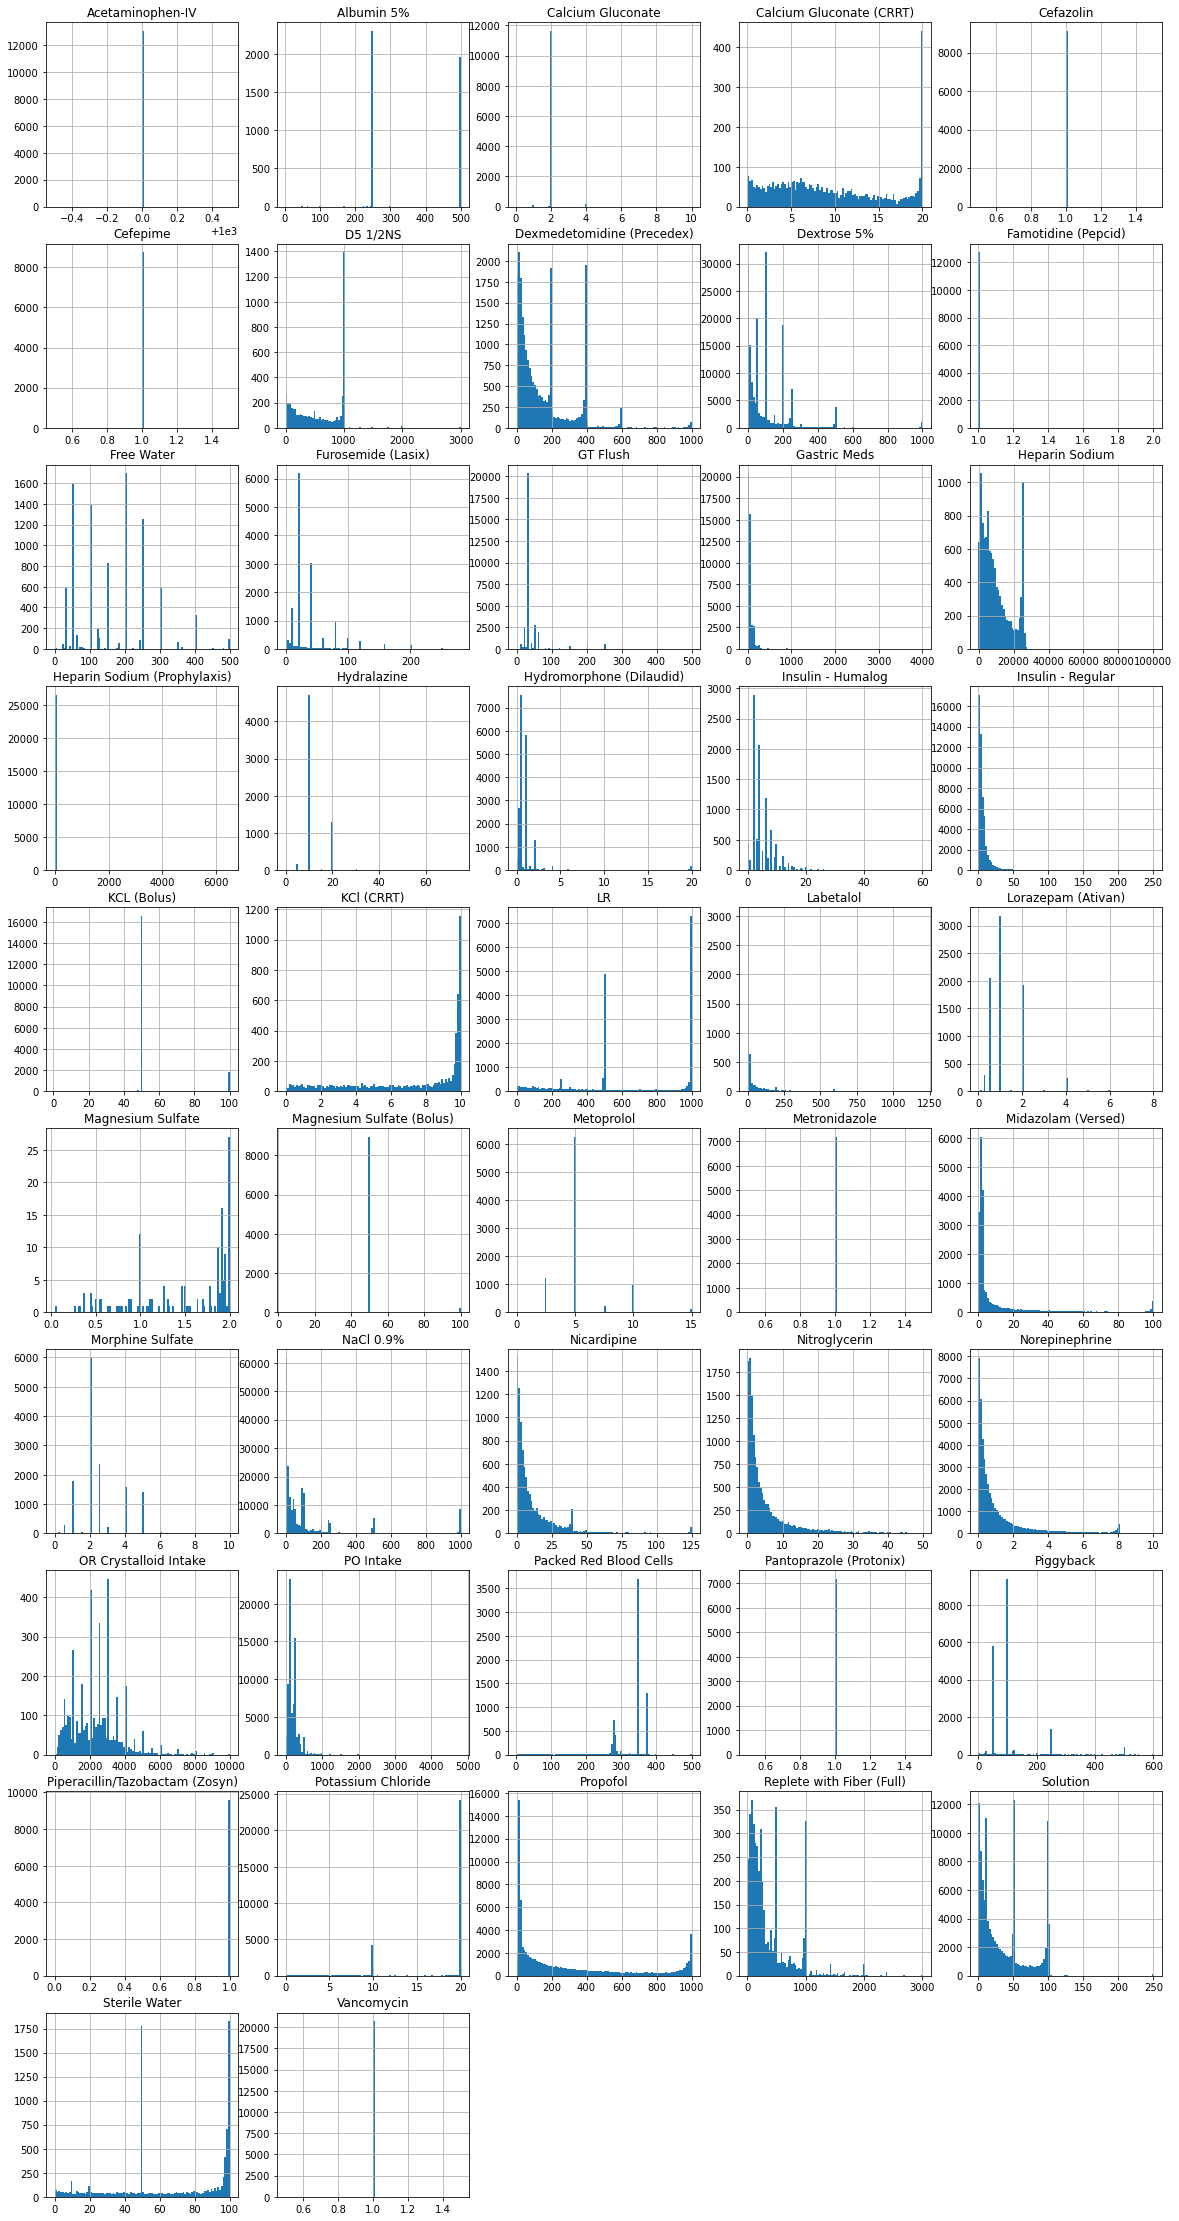

In [31]:
plt.figure(figsize=(20, 40))
for i, label in enumerate(sorted(inp["label"].unique())):
    plt.subplot(10, 5, 1+i)
    inp["amount"][inp["label"] == label].hist(bins=100)
    plt.title(label)

## GaussRank rescaling

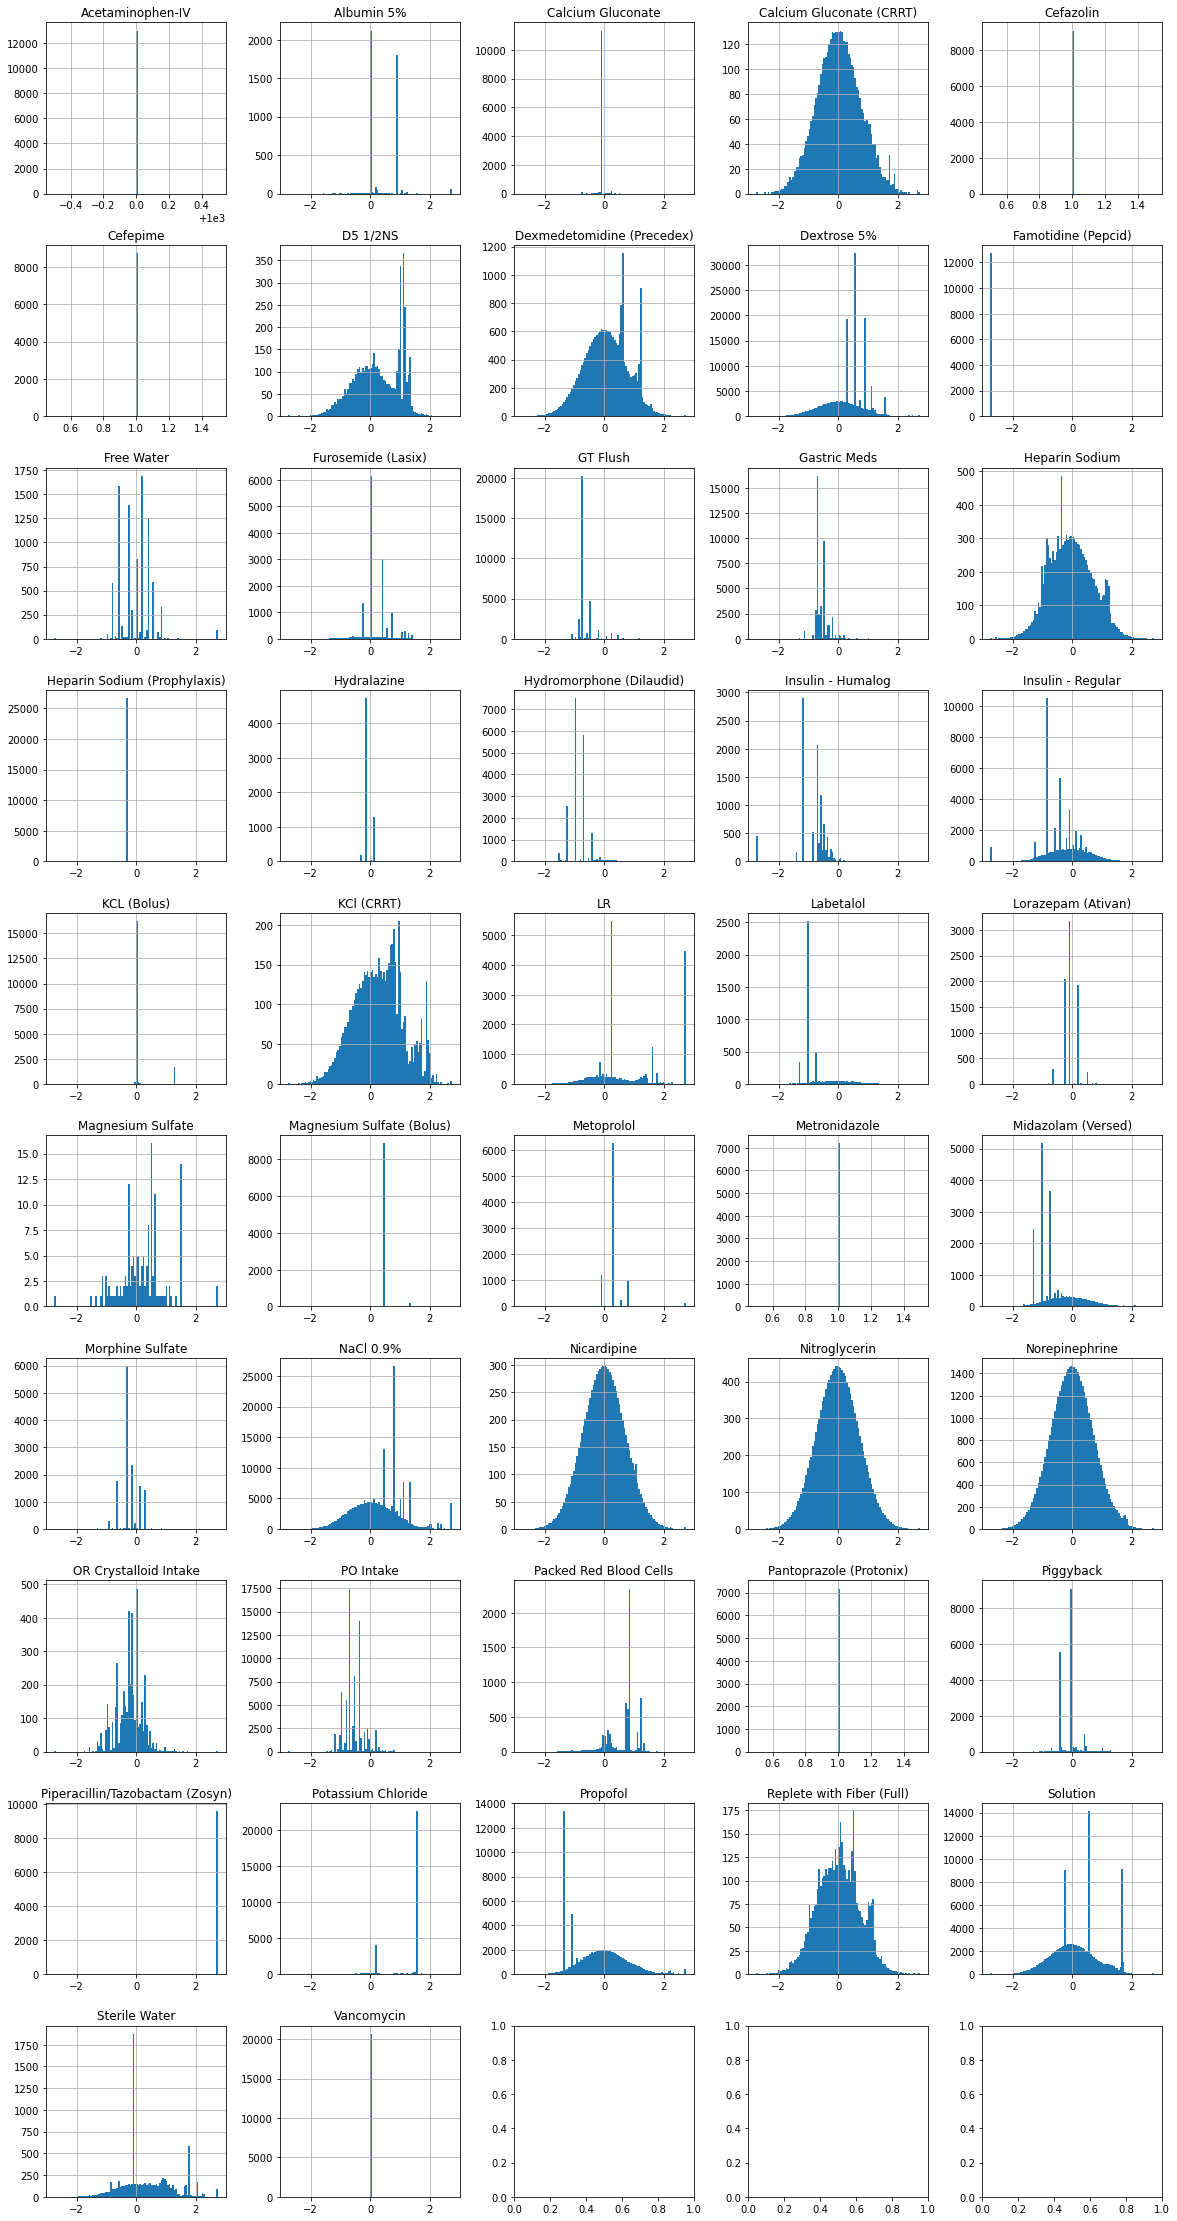

In [32]:
from gauss_rank_scaler import GaussRankScaler

fig, axes = plt.subplots(10, 5, figsize=(20, 40))
axes = [ax for sub_ax in axes for ax in sub_ax]
for i, label in enumerate(sorted(inp["label"].unique())):
    scaler = GaussRankScaler()
    series = inp["amount"][inp["label"] == label]
    if len(np.unique(series)) > 1:
        X_train_new = scaler.fit_transform(series[:, np.newaxis])
    else:
        X_train_new = series[:, np.newaxis]
    pd.DataFrame(X_train_new, columns=[label]).hist(ax=axes[i], bins=100)

In [33]:
inp.to_csv(os.path.join(save_path, 'icu', 'inputevents.csv'))